In [5]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from scipy.stats import pearsonr

Load Time frames V3 and generate table to be updated 

In [6]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

event_labels_df = pd.read_csv(event_csv_path)

fp_mocap_comparison_df = event_labels_df
fp_mocap_comparison_df.drop(columns=['t_foot_up', 'MOCAP_Start_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame', 'MOCAP_End_Time'], inplace=True)

fp_mocap_comparison_df['frame_break'] = fp_mocap_comparison_df['frame_break'].fillna(fp_mocap_comparison_df['frame_end'])

fp_mocap_comparison_df['t_break'] = fp_mocap_comparison_df['t_break'].fillna(fp_mocap_comparison_df['t_foot_down'])

fp_mocap_comparison_df['frame_break'] = fp_mocap_comparison_df['frame_break'].astype(int)
print(fp_mocap_comparison_df.head())

    RADAR_capture  Seconds_per_Frame  tx  is_final_tx  t_stable  t_break  \
0  01_MNTRL_RR_V1            0.03645   1        False     11.19    14.28   
1  01_MNTRL_RR_V1            0.03645   2        False     19.05    22.18   
2  01_MNTRL_RR_V1            0.03645   3         True     27.03    30.57   
3  01_MNTRL_RR_V2            0.03646   1        False     11.05    14.27   
4  01_MNTRL_RR_V2            0.03646   2        False     19.07    22.17   

   t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0        15.05            273           300          384        405  
1        22.83            493           515          601        619  
2        30.57            712           734          831        831  
3        15.05            276           292          380        401  
4        22.86            493           511          596        615  


Add Time-Normalized Force Plate data to new dataframe

In [7]:
# Ensure the DataFrame has the new column initialized to NaN or some default value
fp_mocap_comparison_df['fp_cop_time_norm_length'] = np.nan

for index, row in fp_mocap_comparison_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_FP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_FP_capture_name}.tsv"
    force_plate_capture = FPDataCapture(base_file_path=base_file_path, is_foot_always_up=True)
    
    t_stable = row['t_stable']
    t_end = row['t_foot_down'] if np.isnan(row['t_break']) else row['t_break']
    
    if MOCAP_FP_capture_name == '22_MNTRL_MC_V1' and row['tx'] == "3":
        continue
    elif MOCAP_FP_capture_name == '24_MNTRR_MC_V1' and row['tx'] == "2":
        continue
    
    filtered_data = force_plate_capture.isolate_rows_by_time(t_stable, t_end)
    velocity = None  # Default value in case of insufficient data points
    
    if len(filtered_data.drop_duplicates(subset=['COP_X', 'COP_Y'])) >= 3:
        velocity = force_plate_capture.average_speed(filtered_data)
        # Update the DataFrame directly using the index
        fp_mocap_comparison_df.at[index, 'fp_cop_time_norm_length'] = velocity
        print(f"velocity for {MOCAP_FP_capture_name}, tx {row['tx']} is: {velocity}")
    else:
        print(f"Not enough points to calculate velocity for {MOCAP_FP_capture_name}, tx {row['tx']}")
        

    

velocity for 01_MNTRL_MC_V1, tx 1 is: 0.4076838530012967
velocity for 01_MNTRL_MC_V1, tx 2 is: 0.40403089050665525
velocity for 01_MNTRL_MC_V1, tx 3 is: 0.41494152682943436
velocity for 01_MNTRL_MC_V2, tx 1 is: 0.4006702277966082
velocity for 01_MNTRL_MC_V2, tx 2 is: 0.39992802027388874
velocity for 01_MNTRL_MC_V2, tx 3 is: 0.39830592196013803
velocity for 01_MNTRL_MC_V3, tx 1 is: 0.39298688317725305
velocity for 01_MNTRL_MC_V3, tx 2 is: 0.401534913552597
velocity for 01_MNTRL_MC_V3, tx 3 is: 0.39472329987389276
velocity for 01_MNTRR_MC_V1, tx 1 is: 0.39433209426453375
velocity for 01_MNTRR_MC_V1, tx 2 is: 0.39635744845004217
velocity for 01_MNTRR_MC_V1, tx 3 is: 0.38221618437842086
velocity for 01_MNTRR_MC_V2, tx 1 is: 0.3908773363206526
velocity for 01_MNTRR_MC_V2, tx 2 is: 0.38907469449116716
velocity for 01_MNTRR_MC_V2, tx 3 is: 0.3912731784592932
velocity for 01_MNTRR_MC_V3, tx 1 is: 0.4089041556349955
velocity for 01_MNTRR_MC_V3, tx 2 is: 0.4012909443695887
velocity for 01_MNTRR_

In [8]:
print(fp_mocap_comparison_df.head())

    RADAR_capture  Seconds_per_Frame  tx  is_final_tx  t_stable  t_break  \
0  01_MNTRL_RR_V1            0.03645   1        False     11.19    14.28   
1  01_MNTRL_RR_V1            0.03645   2        False     19.05    22.18   
2  01_MNTRL_RR_V1            0.03645   3         True     27.03    30.57   
3  01_MNTRL_RR_V2            0.03646   1        False     11.05    14.27   
4  01_MNTRL_RR_V2            0.03646   2        False     19.07    22.17   

   t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  \
0        15.05            273           300          384        405   
1        22.83            493           515          601        619   
2        30.57            712           734          831        831   
3        15.05            276           292          380        401   
4        22.86            493           511          596        615   

   fp_cop_time_norm_length  
0                 0.407684  
1                 0.404031  
2                 0.414942  


Load MOCAP Data

In [9]:
# Ensure the necessary columns exist in the DataFrame
for marker in ['Shoulder', 'Wrist', 'Chest', 'Belly']:
    if marker in ['Shoulder', 'Wrist']:
        fp_mocap_comparison_df[f'{marker}_avg_speed'] = np.nan
    else:
        fp_mocap_comparison_df[f'{marker}_speed'] = np.nan

for index, row in fp_mocap_comparison_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_capture = row['RADAR_capture'].replace('_RR_', '_MC_')
    MOCAP_spot_check_path = f"/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/{participant}/tsv/{MOCAP_capture}.tsv"
    
    mocap = MOCAPDataCapture(MOCAP_spot_check_path)
    time_normalized_lengths = mocap.get_time_normalized_length(row['t_stable'], row['t_break'], ['Shoulder', 'Wrist', 'Chest', 'Belly'])
    
    # Update the DataFrame with calculated speeds
    for marker in time_normalized_lengths:
        if marker in ['Shoulder_R', 'Shoulder_L', 'Wrist_R', 'Wrist_L']:
            # Extract base marker name and side
            base_marker, side = marker.rsplit('_', 1)
            # Average the R and L values and update the corresponding column
            if f'{base_marker}_R' in time_normalized_lengths and f'{base_marker}_L' in time_normalized_lengths:
                avg_speed = np.mean([time_normalized_lengths[f'{base_marker}_R'], time_normalized_lengths[f'{base_marker}_L']])
                fp_mocap_comparison_df.at[index, f'{base_marker}_avg_speed'] = avg_speed
        else:
            # Directly update the column for non-side-specific markers
            fp_mocap_comparison_df.at[index, f'{marker}_speed'] = time_normalized_lengths[marker]
    
    print(f"Updated row {index} with time normalized lengths")


Processing File: 01_MNTRL_MC_V1.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_vel.tsv
Updated row 0 with time normalized lengths
Processing File: 01_MNTRL_MC_V1.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_vel.tsv
Updated row 1 with time normalized lengths
Processing File: 01_MNTRL_MC_V1.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_vel.tsv
Updated row 2 with time normalized lengths
Processing File: 01_MNTRL_MC_V2.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V2_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V2_vel.tsv
Updated row 3 with time normalized lengths
Processing File: 01_MNTRL_MC_V2.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V2

Add Time-Normalized MOCAP Data to new dataframe

Calculate Time-Norm for various markers

Add to dataframe

Run Statistical Analysis and Plot Results

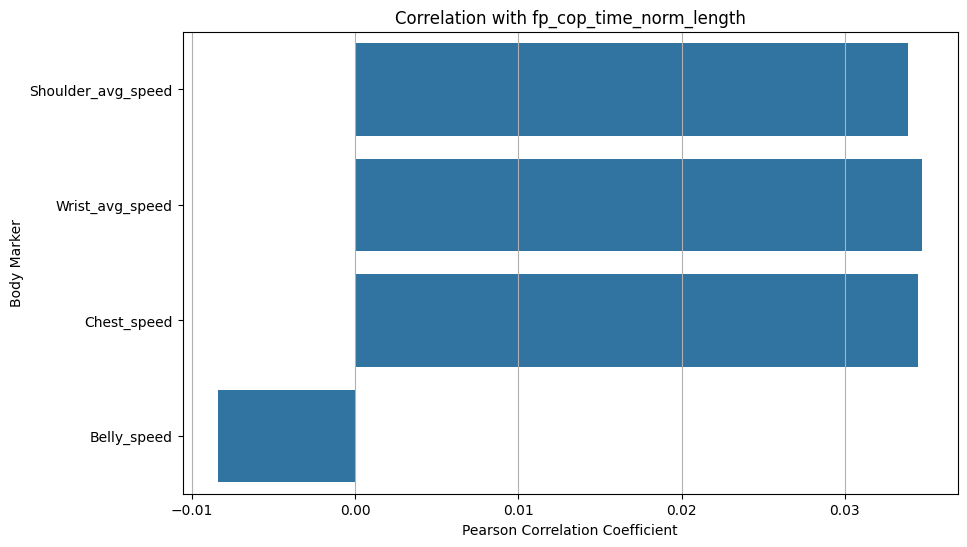

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# List of marker columns to analyze
marker_columns = ['Shoulder_avg_speed', 'Wrist_avg_speed', 'Chest_speed', 'Belly_speed']

# Initialize a list to store correlation results
correlations = []

# Perform correlation analysis
for marker in marker_columns:
    if marker in fp_mocap_comparison_df.columns:
        corr = fp_mocap_comparison_df[marker].corr(fp_mocap_comparison_df['fp_cop_time_norm_length'])
        correlations.append((marker, corr))
    else:
        correlations.append((marker, np.nan))

# Convert the results to a DataFrame for easier plotting
correlation_df = pd.DataFrame(correlations, columns=['Marker', 'Correlation'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Marker', data=correlation_df)
plt.title('Correlation with fp_cop_time_norm_length')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Body Marker')
plt.grid(axis='x')

plt.show()


/var/folders/nh/xjdmv90x37b3xwwbwbm5lp1w0000gn/T/ipykernel_8614/1296369564.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='participant_id', y='Wrist_avg_speed', data=fp_mocap_comparison_df, palette="colorblind")


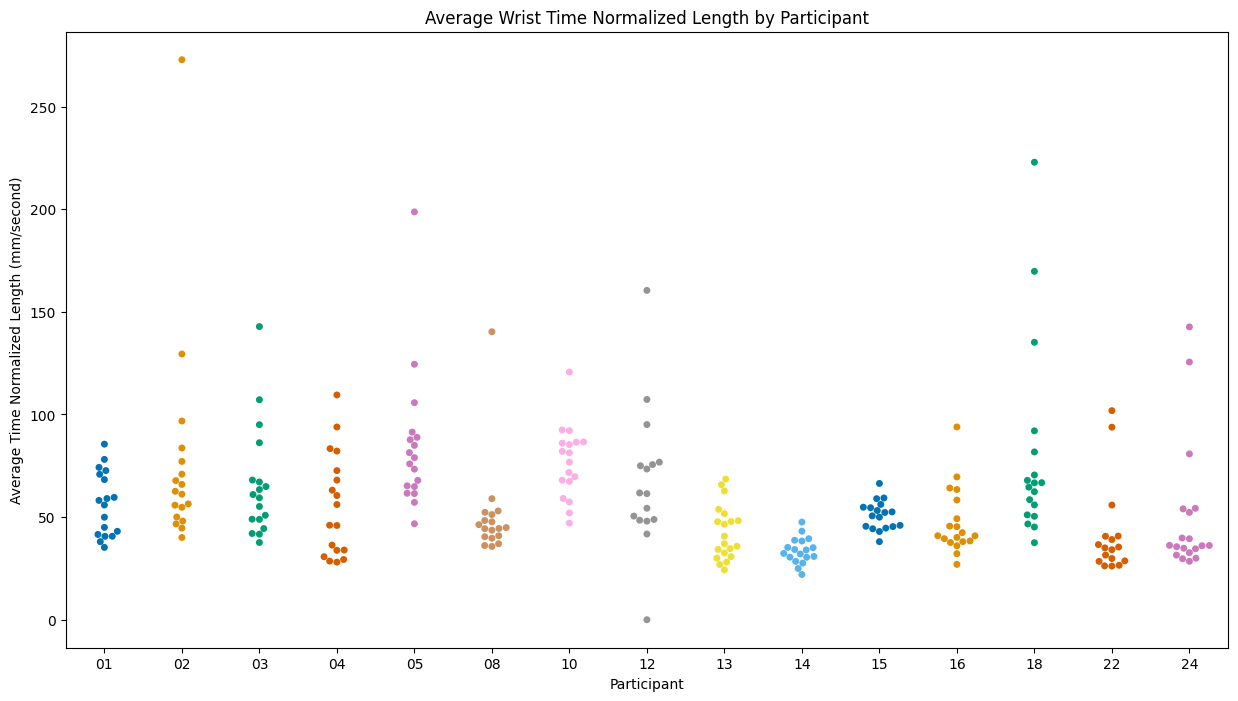

In [16]:
## Extract the first two digits of the RADAR_capture as participant_id
fp_mocap_comparison_df['participant_id'] = fp_mocap_comparison_df['RADAR_capture'].str[:2]

# Creating the plot
plt.figure(figsize=(15, 8))  # Adjust the size as needed to resemble the provided plot
sns.swarmplot(x='participant_id', y='Wrist_avg_speed', data=fp_mocap_comparison_df, palette="colorblind")

# Setting title and labels to match the provided plot
plt.title('Average Wrist Time Normalized Length by Participant')
plt.xlabel('Participant')
plt.ylabel('Average Time Normalized Length (mm/second)')

# This will save the plot to a file on your local system
plt.savefig('Wrist_avg_speed_by_participant.png')

plt.show()

/var/folders/nh/xjdmv90x37b3xwwbwbm5lp1w0000gn/T/ipykernel_8614/3822255982.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='participant_id', y='Chest_speed', data=fp_mocap_comparison_df, palette="colorblind")


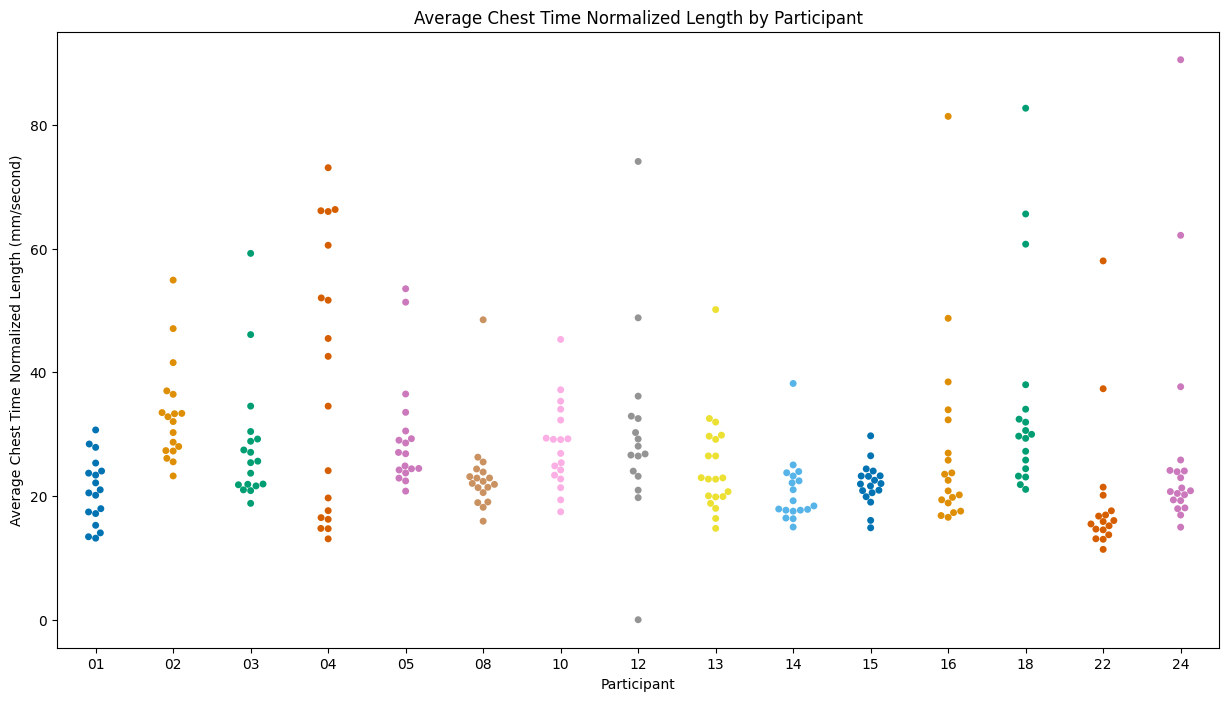

In [17]:
## Extract the first two digits of the RADAR_capture as participant_id
fp_mocap_comparison_df['participant_id'] = fp_mocap_comparison_df['RADAR_capture'].str[:2]

# Creating the plot
plt.figure(figsize=(15, 8))  # Adjust the size as needed to resemble the provided plot
sns.swarmplot(x='participant_id', y='Chest_speed', data=fp_mocap_comparison_df, palette="colorblind")

# Setting title and labels to match the provided plot
plt.title('Average Chest Time Normalized Length by Participant')
plt.xlabel('Participant')
plt.ylabel('Average Chest Time Normalized Length (mm/second)')

# This will save the plot to a file on your local system
plt.savefig('chest_speed_by_participant.png')

plt.show()

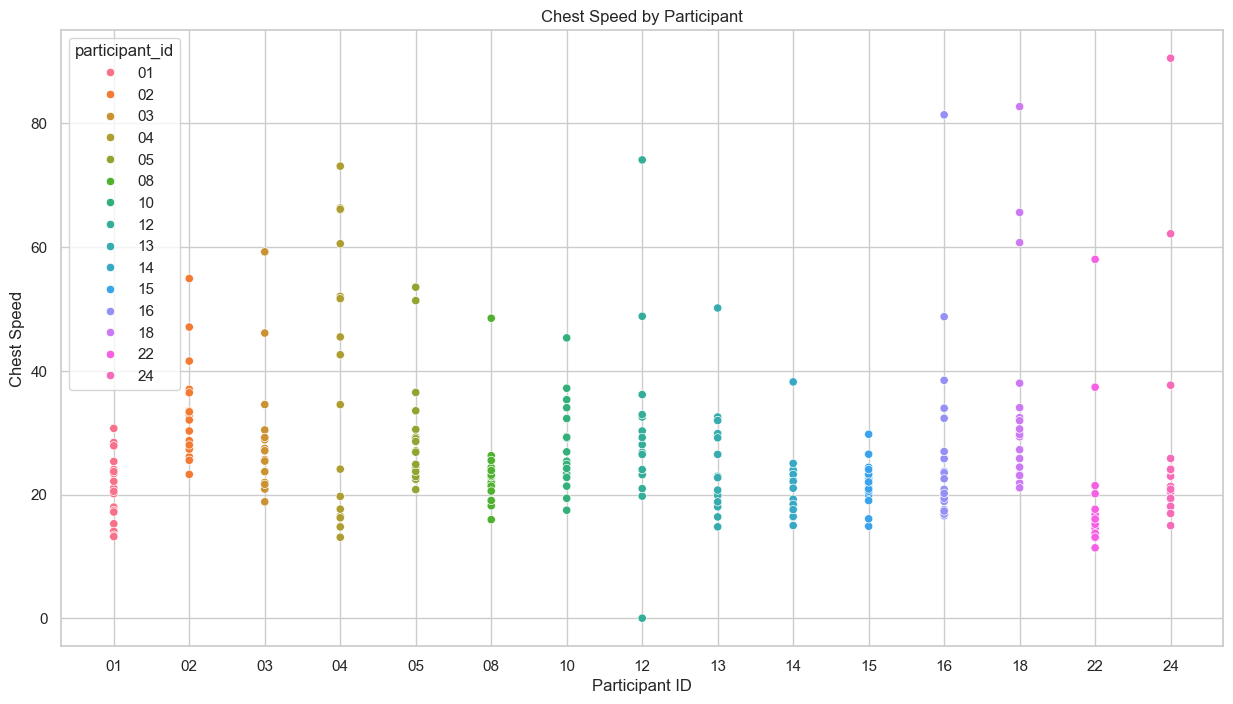

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import mplcursors

# Extract the first two digits of the RADAR_capture as participant_id
fp_mocap_comparison_df['participant_id'] = fp_mocap_comparison_df['RADAR_capture'].str[:2]

# Create the plot
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")  # Set style for seaborn plots
plot = sns.scatterplot(x='participant_id', y='Chest_speed', data=fp_mocap_comparison_df, hue='participant_id')

# Add mplcursors for interactivity with hover
mplcursors.cursor(hover=True).connect(
    "add", lambda sel: sel.annotation.set_text(
        f"RADAR: {fp_mocap_comparison_df.iloc[sel.target.index]['RADAR_capture']}\n"
        f"tx: {fp_mocap_comparison_df.iloc[sel.target.index]['tx']}"
    )
)

plt.title('Chest Speed by Participant')
plt.xlabel('Participant ID')
plt.ylabel('Chest Speed')
plt.show()

Highest Chest speeds

In [22]:
# Now sort the DataFrame by 'Chest_speed' in descending order and take the first 5 rows
top_chest_speeds = fp_mocap_comparison_df.nlargest(5, 'Chest_speed')

# Print the top 5 rows with the highest 'Chest_speed'
top_chest_speeds

,RADAR_capture,Seconds_per_Frame,tx,is_final_tx,t_stable,t_break,t_foot_down,frame_foot_up,frame_stable,frame_break,frame_end,fp_cop_time_norm_length,Shoulder_avg_speed,Wrist_avg_speed,Chest_speed,Belly_speed,participant_id
262,24_MNTRR_RR_V1,0.03761,2,False,13.62,13.77,14.21000,345,355,359,371,0.434350,118.562730,142.663860,90.564067,60.717926,24
218,18_MNTRL_RR_V1,0.03776,2,False,18.67,22.12,22.48000,474,486,578,587,0.465431,79.352103,169.737536,82.723530,77.311791,18
204,16_MNTRL_RR_V2,0.03836,3,True,26.72,30.74,30.74000,675,688,793,793,0.507822,88.278570,93.927495,81.403499,86.582264,16
137,12_MNTRR_RR_V2,0.03805,2,False,18.83,22.31,23.08250,472,488,580,600,0.358226,87.313895,160.451942,74.112868,57.139964,12
58,04_MNTRL_RR_V2,0.03775,2,False,19.90,22.39,22.91417,468,513,579,593,0.306663,85.227795,93.891208,73.102542,75.607379,04


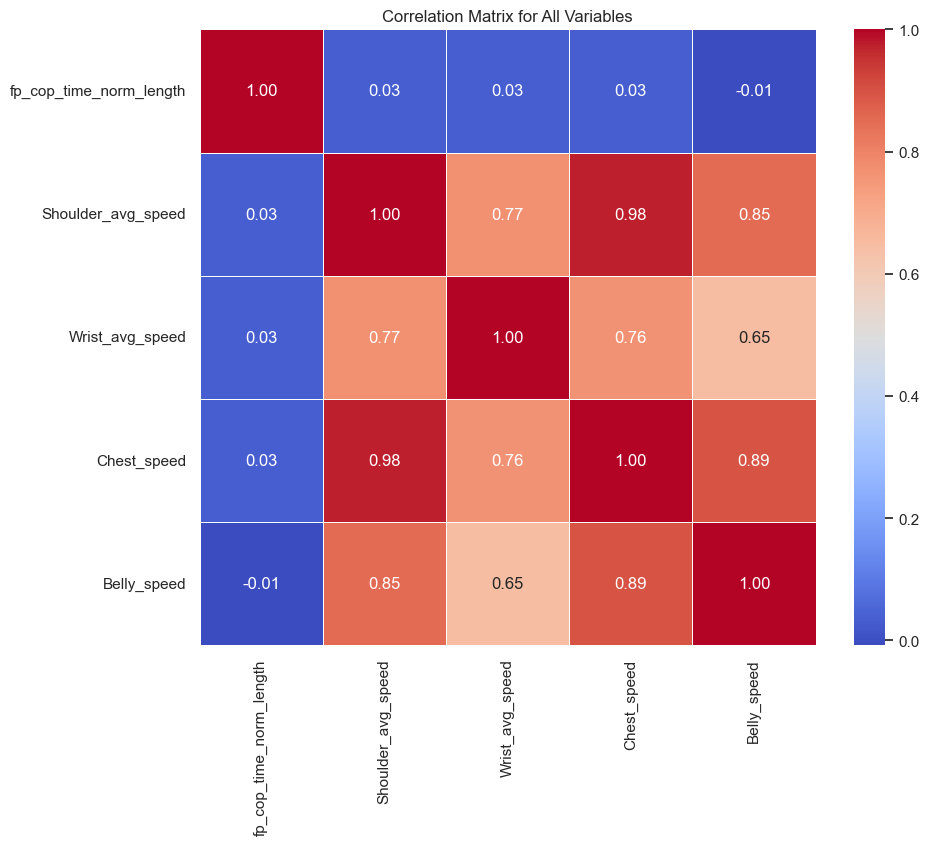

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'fp_mocap_comparison_df' is your DataFrame and it includes the following columns
# For demonstration, I'm creating a mock DataFrame with random data
np.random.seed(0)  # For reproducibility

temp_matrix = fp_mocap_comparison_df[['fp_cop_time_norm_length',	'Shoulder_avg_speed','Wrist_avg_speed',	'Chest_speed',	'Belly_speed']]

# Calculating the correlation matrix
correlation_matrix = temp_matrix.corr()

# Creating the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix for All Variables')
plt.show()